# 4. Predictive Analytics

- Since the **total system-level demand in the next hour** is of our interest, the station-dependent demand is not needed in this task.
- Our target value is `y = numOfRentedBikes`

In [1]:
# Import all necessary packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from scipy.stats import loguniform
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, train_test_split

# Import keras libraries
import tensorflow
from tensorflow import keras
from keras import layers
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# import dataset (which we created in Task 1)
dfPhiladelphiaIncluding0TripsUniqueHours = pd.read_csv("data/exports/dfPhiladelphiaIncluding0TripsUniqueHours.csv.zip")
dfPhiladelphiaIncluding0TripsUniqueHours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   start_month             8760 non-null   int64  
 1   start_week              8760 non-null   int64  
 2   start_day               8760 non-null   int64  
 3   start_time_hourly       8760 non-null   int64  
 4   min_temp                8760 non-null   float64
 5   max_temp                8760 non-null   float64
 6   isPrecip                8760 non-null   bool   
 7   dayOfWeek               8760 non-null   object 
 8   isWeekend               8760 non-null   bool   
 9   season                  8760 non-null   object 
 10  isHoliday               8760 non-null   bool   
 11  isRushhour              8760 non-null   bool   
 12  numOfRentedBikesHourly  8760 non-null   int64  
dtypes: bool(4), float64(2), int64(5), object(2)
memory usage: 650.3+ KB


In [2]:
dfPhiladelphiaIncluding0TripsUniqueHours

,start_month,start_week,start_day,start_time_hourly,min_temp,max_temp,isPrecip,dayOfWeek,isWeekend,season,isHoliday,isRushhour,numOfRentedBikesHourly
0,1,1,1,0,6.4,6.950,True,Tuesday,False,winter,True,False,2
1,1,1,1,1,6.8,7.075,True,Tuesday,False,winter,True,False,8
2,1,1,1,2,7.2,7.200,True,Tuesday,False,winter,True,False,10
3,1,1,1,3,7.8,8.050,True,Tuesday,False,winter,True,False,7
4,1,1,1,4,8.3,9.400,True,Tuesday,False,winter,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12,1,31,19,7.1,7.375,False,Tuesday,False,winter,False,True,44
8756,12,1,31,20,7.8,7.800,False,Tuesday,False,winter,False,False,33
8757,12,1,31,21,8.3,8.300,False,Tuesday,False,winter,False,False,24
8758,12,1,31,22,8.3,8.300,False,Tuesday,False,winter,False,False,26


## 4.1 Feature Engineering

In this subtask, we will:
- Develop a rich set of features that we expect to be correlated with our target (**Already done in Task 1**)
- We will justify the selection of features

**!The feature creation process was already done in task 1!**  

In [3]:
# Replace values with Integer values
dfPhiladelphiaIncluding0TripsUniqueHours['dayOfWeek'] = dfPhiladelphiaIncluding0TripsUniqueHours['dayOfWeek'].replace(['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[0,1,2,3,4,5,6])

# Replace values with Integer values
dfPhiladelphiaIncluding0TripsUniqueHours['season'] = dfPhiladelphiaIncluding0TripsUniqueHours['season'].replace(['summer', 'winter','spring','autumn'],[0,1,2,3])

dfPhiladelphiaIncluding0TripsUniqueHours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   start_month             8760 non-null   int64  
 1   start_week              8760 non-null   int64  
 2   start_day               8760 non-null   int64  
 3   start_time_hourly       8760 non-null   int64  
 4   min_temp                8760 non-null   float64
 5   max_temp                8760 non-null   float64
 6   isPrecip                8760 non-null   bool   
 7   dayOfWeek               8760 non-null   int64  
 8   isWeekend               8760 non-null   bool   
 9   season                  8760 non-null   int64  
 10  isHoliday               8760 non-null   bool   
 11  isRushhour              8760 non-null   bool   
 12  numOfRentedBikesHourly  8760 non-null   int64  
dtypes: bool(4), float64(2), int64(7)
memory usage: 650.3 KB


### 4.1.1 Justify the selection of features 

We definitely need:
- 'numOfRentedBikesHourly', because this is our target value
- 'start_time_hourly', because we want to predict the demand in the next hour (so this is like "the" main input)

We will test/evaluate if we need the following features:
- 'start_month', 'start_week' & 'start_day'
- 'min_temp' & 'max_temp'
- 'isPrecip'
- 'dayOfWeek'
- 'isWeekend'
- 'season'
- 'isHoliday'
- 'isRushhour'

For the test/evaluation we will use:
- Variance Criteria
- Correlation Criteria

#### Variance:

In [4]:
dfPhiladelphiaIncluding0TripsUniqueHours[['start_month', 'start_week', 'start_day', 'min_temp', 'max_temp', 'isPrecip', 'dayOfWeek', 'isWeekend', 'season', 'isHoliday', 'isRushhour', 'start_time_hourly', 'numOfRentedBikesHourly']].var()

start_month                 11.889036
start_week                 226.435352
start_day                   77.382795
min_temp                   103.864476
max_temp                   104.211228
isPrecip                     0.078957
dayOfWeek                    4.000427
isWeekend                    0.203769
season                       1.258271
isHoliday                    0.026650
isRushhour                   0.206621
start_time_hourly           47.922137
numOfRentedBikesHourly    4310.690580
dtype: float64

- min_temp & max_temp almost the same variance --> One of them is a candidate for getting dropped, we will investigate this further in the Correlation Matrix

#### Correlations

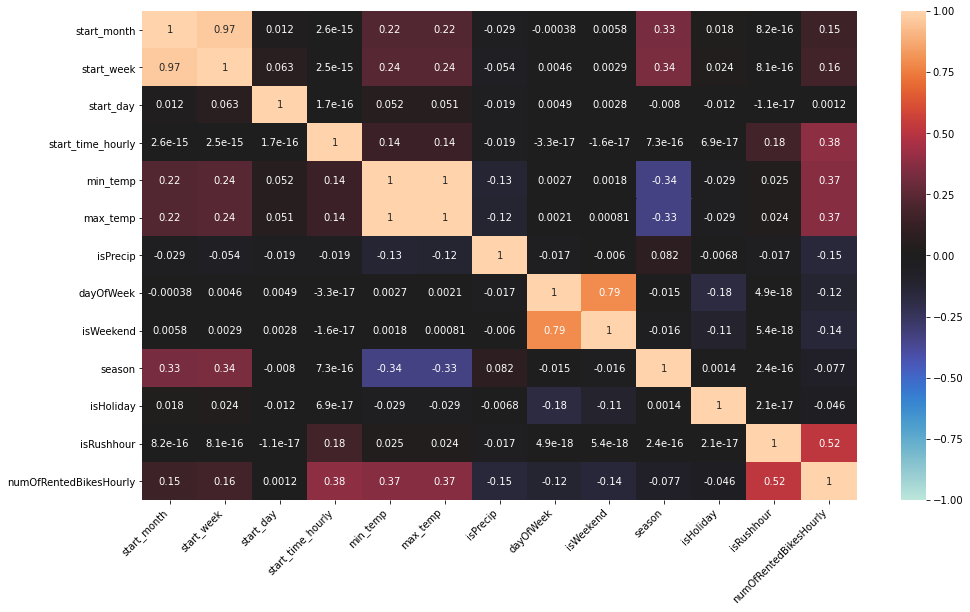

In [5]:
corr = dfPhiladelphiaIncluding0TripsUniqueHours.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

#### Feature selection:
- We will drop `max_temp` or `min_temp`, because they are perfectly correlated.  
- We will also drop `start_week`, because it has a very high correlation with start_month & we know from domain knowledge that if we take start_month & start_day as inputs for our models the feature start_week is very likely to add no additional value.  
- We will keep all other features as they are significantly enough correlated with our target value `numOfRentedBikesHourly`.  
- Our feature with the most "impact" (correlation to `numOfRentedBikesHourly`) is: `isRushour`

#### Our selected features:

In [6]:
dfPhiladelphiaIncluding0TripsUniqueHours.drop(columns = ['min_temp', 'start_week'], inplace = True)
dfPhiladelphiaIncluding0TripsUniqueHours

,start_month,start_day,start_time_hourly,max_temp,isPrecip,dayOfWeek,isWeekend,season,isHoliday,isRushhour,numOfRentedBikesHourly
0,1,1,0,6.950,True,1,False,1,True,False,2
1,1,1,1,7.075,True,1,False,1,True,False,8
2,1,1,2,7.200,True,1,False,1,True,False,10
3,1,1,3,8.050,True,1,False,1,True,False,7
4,1,1,4,9.400,True,1,False,1,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...
8755,12,31,19,7.375,False,1,False,1,False,True,44
8756,12,31,20,7.800,False,1,False,1,False,False,33
8757,12,31,21,8.300,False,1,False,1,False,False,24
8758,12,31,22,8.300,False,1,False,1,False,False,26


## 4.2 Model Building & Evaluation

In [7]:
# Function for normalization of numerical and for encoding categorical features and for creation of pipelines

def pipeline_for_prediction(categoric, numeric, model):
    
    numeric_transformer = Pipeline(steps=[("standard_scaler", StandardScaler())])
    categorical_transformer = Pipeline(
        steps=[("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical scaler", numeric_transformer, numeric),
            ("one hot encoder", categorical_transformer, categoric),
        ]
    )
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model)]
    )
    return pipeline

In [8]:
# Defining categorical and numeric features of dfPhiladelphiaIncluding0TripsUniqueHours

categoric = ['start_month', 'start_day','start_time_hourly','isPrecip','dayOfWeek','isWeekend','season',
             'isHoliday','isRushhour']
numeric = ['max_temp']

In [9]:
# Function for getting different scores for a model

def get_prediction_scores(y_true, y_predicted):
    print("MODEL SCORES:")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_predicted): .3f}")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_predicted): .3f}")
    print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_true, y_predicted)): .3f}")
    print(f"Accuracy:", round((1-(metrics.mean_absolute_error(y_true, y_predicted)/dfPhiladelphiaIncluding0TripsUniqueHours["numOfRentedBikesHourly"].mean()))*100,2), "%")
    print(f"R2: {100 * metrics.r2_score(y_true, y_predicted): .3f} %")
    print(f"Max Residual Error: {metrics.max_error(y_true, y_predicted): .3f}")

In [10]:
# Function for creating pipeline and fitting model (created by the pipeline), predict and printing scores

def pipeline_fit_predict(reg, categoric, numeric, x_train, y_train, x_test, y_test):
    pipeline = pipeline_for_prediction(categoric, numeric, reg)
    pipeline.fit(x_train, y_train)
    y_predict = pipeline.predict(x_test)
    get_prediction_scores(y_test, y_predict)

In [11]:
# Function for finding the best hyperparameter by using RandomizedSearchCV and RepeatedStratifiedKFold
"""parameter:
   - pipeline: used pipeline for grid search (the pipeline contains the model)
   - x_val: data set (features) used for grid search
   - y_val: data set (target value) used for grid search
   - model_par: parameters for which the grid search is done
   - score: used score measure 
   - n_iter: how often grid search will be done
   - n_repeats: how often the data set is randomly splitted (by using the same random hyperparameter) in n_splits
   - n_splits: number of splits in RepeatedStratifiedKFold
   - verbose: getting information during the grid search
"""

def find_best_hyperparameters(pipeline, x_val, y_val, model_par, score, n_iter = 50,  
                                   n_repeats=3, n_splits=5, n_jobs=1, verbose=True):
    
    print(f"Running grid search for the model based on {score}")
    grid_pipeline = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=model_par,
        n_jobs=n_jobs,
        n_iter=n_iter,
        cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42),
        scoring=score,
        random_state=42,
        verbose=verbose,
    )
    grid_pipeline.fit(x_val, y_val)
    print(f"Best {score} Score was: {grid_pipeline.best_score_}")
    print("The best hyper parameters for the model are:")
    print(grid_pipeline.best_params_)

**Split the dataset in trainset, validationset and testset (50-20-30)**

In [12]:
# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(dfPhiladelphiaIncluding0TripsUniqueHours.drop('numOfRentedBikesHourly', axis=1)
                                                    , dfPhiladelphiaIncluding0TripsUniqueHours['numOfRentedBikesHourly'], 
                                                    test_size=0.3,random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model

### 4.2.1 Lasso Regression

Using Lasso Regression to predict the `numOfRentedBikesHourly`.

In [13]:
# Creating the regression model
lasso_reg = Lasso()

**Looking for the best Hyperparameters**

In [14]:
# Creating the ranges for model parameter to use in find_best_hyperparameters
model_para = {'model__alpha': loguniform(1e-2, 1e2),
              'model__tol' : loguniform(1e-5,1e0)
             }

In [15]:
pipeline = pipeline_for_prediction(categoric, numeric, lasso_reg)

In [16]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 1/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1224.608 total time=   0.0s
[CV 2/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 2/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1492.931 total time=   0.0s
[CV 3/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 3/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1208.652 total time=   0.0s
[CV 4/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 4/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1611.100 total time=   0.0s
[CV 5/15; 1/50] START model__alpha=0.314891164795686, model

C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"



[CV 7/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1308.676 total time=   0.0s
[CV 8/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 8/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1399.007 total time=   0.0s
[CV 9/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 9/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1520.075 total time=   0.0s
[CV 10/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 10/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1455.573 total time=   0.0s
[CV 11/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 11/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1236.521 total time=   0.0s
[CV 12/15; 1/50] START model__alpha=0.314891164795686, model__to

[CV 5/15; 4/50] START model__alpha=0.017073967431528118, model__tol=0.21423021757741056
[CV 5/15; 4/50] END model__alpha=0.017073967431528118, model__tol=0.21423021757741056;, score=-1328.115 total time=   0.0s
[CV 6/15; 4/50] START model__alpha=0.017073967431528118, model__tol=0.21423021757741056
[CV 6/15; 4/50] END model__alpha=0.017073967431528118, model__tol=0.21423021757741056;, score=-1284.508 total time=   0.0s
[CV 7/15; 4/50] START model__alpha=0.017073967431528118, model__tol=0.21423021757741056
[CV 7/15; 4/50] END model__alpha=0.017073967431528118, model__tol=0.21423021757741056;, score=-1291.697 total time=   0.0s
[CV 8/15; 4/50] START model__alpha=0.017073967431528118, model__tol=0.21423021757741056
[CV 8/15; 4/50] END model__alpha=0.017073967431528118, model__tol=0.21423021757741056;, score=-1392.319 total time=   0.0s
[CV 9/15; 4/50] START model__alpha=0.017073967431528118, model__tol=0.21423021757741056
[CV 9/15; 4/50] END model__alpha=0.017073967431528118, model__tol=0.

[CV 4/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 4/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-4639.601 total time=   0.0s
[CV 5/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 5/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-4344.709 total time=   0.0s
[CV 6/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 6/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-3896.706 total time=   0.0s
[CV 7/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 7/15; 7/50] END model__alpha=21.368329072358737, model__tol=0.00011526449540315609;, score=-4311.179 total time=   0.0s
[CV 8/15; 7/50] START model__alpha=21.368329072358737, model__tol=0.00011526449540315609
[CV 8/15; 7/50] END model__alpha=21.368329072358737, model_

[CV 14/15; 9/50] END model__alpha=0.16480446427978965, model__tol=0.0042051564509138694;, score=-1522.307 total time=   0.0s
[CV 15/15; 9/50] START model__alpha=0.16480446427978965, model__tol=0.0042051564509138694
[CV 15/15; 9/50] END model__alpha=0.16480446427978965, model__tol=0.0042051564509138694;, score=-1522.355 total time=   0.0s
[CV 1/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 1/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1422.564 total time=   0.0s
[CV 2/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 2/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1665.592 total time=   0.0s
[CV 3/15; 10/50] START model__alpha=0.5342937261279772, model__tol=0.00028585493941961907
[CV 3/15; 10/50] END model__alpha=0.5342937261279772, model__tol=0.00028585493941961907;, score=-1354.455 total time=   0.0s
[CV 4/15; 10/50

[CV 8/15; 12/50] END model__alpha=0.14742753159914665, model__tol=0.0006789053271698486;, score=-1365.884 total time=   0.0s
[CV 9/15; 12/50] START model__alpha=0.14742753159914665, model__tol=0.0006789053271698486
[CV 9/15; 12/50] END model__alpha=0.14742753159914665, model__tol=0.0006789053271698486;, score=-1443.654 total time=   0.0s
[CV 10/15; 12/50] START model__alpha=0.14742753159914665, model__tol=0.0006789053271698486
[CV 10/15; 12/50] END model__alpha=0.14742753159914665, model__tol=0.0006789053271698486;, score=-1416.090 total time=   0.0s
[CV 11/15; 12/50] START model__alpha=0.14742753159914665, model__tol=0.0006789053271698486
[CV 11/15; 12/50] END model__alpha=0.14742753159914665, model__tol=0.0006789053271698486;, score=-1216.427 total time=   0.0s
[CV 12/15; 12/50] START model__alpha=0.14742753159914665, model__tol=0.0006789053271698486
[CV 12/15; 12/50] END model__alpha=0.14742753159914665, model__tol=0.0006789053271698486;, score=-1290.164 total time=   0.0s
[CV 13/15

[CV 8/15; 15/50] START model__alpha=2.34238498471129, model__tol=1.707072883030664e-05
[CV 8/15; 15/50] END model__alpha=2.34238498471129, model__tol=1.707072883030664e-05;, score=-2322.219 total time=   0.0s
[CV 9/15; 15/50] START model__alpha=2.34238498471129, model__tol=1.707072883030664e-05
[CV 9/15; 15/50] END model__alpha=2.34238498471129, model__tol=1.707072883030664e-05;, score=-2874.232 total time=   0.0s
[CV 10/15; 15/50] START model__alpha=2.34238498471129, model__tol=1.707072883030664e-05
[CV 10/15; 15/50] END model__alpha=2.34238498471129, model__tol=1.707072883030664e-05;, score=-2727.744 total time=   0.0s
[CV 11/15; 15/50] START model__alpha=2.34238498471129, model__tol=1.707072883030664e-05
[CV 11/15; 15/50] END model__alpha=2.34238498471129, model__tol=1.707072883030664e-05;, score=-2300.043 total time=   0.0s
[CV 12/15; 15/50] START model__alpha=2.34238498471129, model__tol=1.707072883030664e-05
[CV 12/15; 15/50] END model__alpha=2.34238498471129, model__tol=1.707072

[CV 7/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-4397.374 total time=   0.0s
[CV 8/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 8/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-4279.768 total time=   0.0s
[CV 9/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 9/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-4736.894 total time=   0.0s
[CV 10/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 10/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-4448.105 total time=   0.0s
[CV 11/15; 18/50] START model__alpha=72.86653737491037, model__tol=0.11015056790269624
[CV 11/15; 18/50] END model__alpha=72.86653737491037, model__tol=0.11015056790269624;, score=-3992.944 total time=   0.0s
[CV 12/15; 18/50] START model__alpha=72.8665373

[CV 2/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1469.200 total time=   0.0s
[CV 3/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 3/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1147.476 total time=   0.0s
[CV 4/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 4/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1601.076 total time=   0.0s
[CV 5/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 5/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1294.552 total time=   0.0s
[CV 6/15; 21/50] START model__alpha=0.030771802712506853, model__tol=0.0029914693021302146
[CV 6/15; 21/50] END model__alpha=0.030771802712506853, model__tol=0.0029914693021302146;, score=-1297.155 total time=   0.0s
[CV 7/

[CV 14/15; 23/50] START model__alpha=0.10842262717330158, model__tol=0.020540519425388454
[CV 14/15; 23/50] END model__alpha=0.10842262717330158, model__tol=0.020540519425388454;, score=-1516.859 total time=   0.0s
[CV 15/15; 23/50] START model__alpha=0.10842262717330158, model__tol=0.020540519425388454
[CV 15/15; 23/50] END model__alpha=0.10842262717330158, model__tol=0.020540519425388454;, score=-1502.923 total time=   0.0s
[CV 1/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 1/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1228.899 total time=   0.0s
[CV 2/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 2/15; 24/50] END model__alpha=0.17654048052495064, model__tol=0.003984190594434687;, score=-1480.111 total time=   0.0s
[CV 3/15; 24/50] START model__alpha=0.17654048052495064, model__tol=0.003984190594434687
[CV 3/15; 24/50] END model__alpha=0.17654048052495064, 

[CV 1/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-3992.944 total time=   0.0s
[CV 2/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 2/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4397.374 total time=   0.0s
[CV 3/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 3/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4279.768 total time=   0.0s
[CV 4/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 4/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4736.894 total time=   0.0s
[CV 5/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 5/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4448.105 total time=   0.0s
[CV 6/15; 27/50] START model__alpha=57.279

[CV 11/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1227.098 total time=   0.1s
[CV 12/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 12/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1272.807 total time=   0.0s
[CV 13/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 13/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1147.111 total time=   0.0s
[CV 14/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 14/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1552.111 total time=   0.0s
[CV 15/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 15/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1493.584 total time=   0.

[CV 6/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 6/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.000607808309968195;, score=-3869.168 total time=   0.0s
[CV 7/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 7/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.000607808309968195;, score=-4281.038 total time=   0.0s
[CV 8/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 8/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.000607808309968195;, score=-4203.285 total time=   0.0s
[CV 9/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 9/15; 32/50] END model__alpha=20.651425578959245, model__tol=0.000607808309968195;, score=-4607.086 total time=   0.0s
[CV 10/15; 32/50] START model__alpha=20.651425578959245, model__tol=0.000607808309968195
[CV 10/15; 32/50] END model__alpha=20.651425578959245, model__tol=0

[CV 1/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 1/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1207.207 total time=   0.0s
[CV 2/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 2/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1474.838 total time=   0.0s
[CV 3/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 3/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1172.188 total time=   0.0s
[CV 4/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 4/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1618.065 total time=   0.0s
[CV 5/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 5/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.859873733

[CV 9/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1431.899 total time=   0.0s
[CV 10/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 10/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1366.462 total time=   0.0s
[CV 11/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 11/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1233.963 total time=   0.0s
[CV 12/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 12/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1273.284 total time=   0.0s
[CV 13/15; 37/50] START model__alpha=0.010521761868451128, model__tol=0.11948328168545436
[CV 13/15; 37/50] END model__alpha=0.010521761868451128, model__tol=0.11948328168545436;, score=-1150.911 total time=   0.0s
[CV 14/15; 37/50

[CV 4/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1617.804 total time=   0.0s
[CV 5/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 5/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1367.708 total time=   0.0s
[CV 6/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 6/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1303.125 total time=   0.0s
[CV 7/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 7/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1295.564 total time=   0.0s
[CV 8/15; 40/50] START model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05
[CV 8/15; 40/50] END model__alpha=0.2715581955282939, model__tol=3.7961668958008126e-05;, score=-1381.813 total time=   0.0s
[CV 9/15; 40/50

[CV 13/15; 42/50] END model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05;, score=-1170.683 total time=   0.0s
[CV 14/15; 42/50] START model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05
[CV 14/15; 42/50] END model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05;, score=-1528.928 total time=   0.0s
[CV 15/15; 42/50] START model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05
[CV 15/15; 42/50] END model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05;, score=-1544.258 total time=   0.0s
[CV 1/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 1/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1229.268 total time=   0.0s
[CV 2/15; 43/50] START model__alpha=0.17535949529764414, model__tol=0.00042258746449961676
[CV 2/15; 43/50] END model__alpha=0.17535949529764414, model__tol=0.00042258746449961676;, score=-1480.930 total time=   0.0s
[CV 3/

[CV 13/15; 45/50] START model__alpha=35.387588647792384, model__tol=0.002296543234463434
[CV 13/15; 45/50] END model__alpha=35.387588647792384, model__tol=0.002296543234463434;, score=-4279.768 total time=   0.0s
[CV 14/15; 45/50] START model__alpha=35.387588647792384, model__tol=0.002296543234463434
[CV 14/15; 45/50] END model__alpha=35.387588647792384, model__tol=0.002296543234463434;, score=-4736.894 total time=   0.0s
[CV 15/15; 45/50] START model__alpha=35.387588647792384, model__tol=0.002296543234463434
[CV 15/15; 45/50] END model__alpha=35.387588647792384, model__tol=0.002296543234463434;, score=-4448.105 total time=   0.0s
[CV 1/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 1/15; 46/50] END model__alpha=0.030086868214458433, model__tol=0.03683188416535899;, score=-1224.207 total time=   0.0s
[CV 2/15; 46/50] START model__alpha=0.030086868214458433, model__tol=0.03683188416535899
[CV 2/15; 46/50] END model__alpha=0.030086868214458433, mod

[CV 6/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3137.950 total time=   0.0s
[CV 7/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 7/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3503.671 total time=   0.0s
[CV 8/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 8/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3296.391 total time=   0.0s
[CV 9/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 9/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3864.150 total time=   0.0s
[CV 10/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 10/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3587.797 total time=   0.0s
[CV 11/15; 48/50] STAR

[CV 15/15; 50/50] END model__alpha=0.012637946338082871, model__tol=3.463037026119183e-05;, score=-1495.624 total time=   0.1s
Best neg_mean_squared_error Score was: -1339.3234438251673
The best hyper parameters for the model are:
{'model__alpha': 0.10842262717330158, 'model__tol': 0.020540519425388454}


**Training & Evaluation of the model with the best hyperparameters**

In [17]:
lasso_reg_end = Lasso(alpha=0.10842262717330158, tol = 0.020540519425388454)

In [18]:
pipeline_end = pipeline_fit_predict(lasso_reg_end, categoric, numeric, x_train, y_train, x_test, y_test)

MODEL SCORES:
MAE:  26.667
MSE:  1365.054
RMSE:  36.947
Accuracy: 60.35 %
R2:  69.394 %
Max Residual Error:  182.335


### 4.2.2 Random Forest Regression

Using Random Forest Regression to predict the `numOfRentedBikesHourly`.

In [19]:
# Creating the regression model
forest_reg = RandomForestRegressor(n_estimators = 10,criterion="friedman_mse", random_state=42) 

**Looking for the best Hyperparameters**

In [20]:
# Creating the ranges for model parameter to use in find_best_hyperparameters
model_para = {'model__max_depth': range(1,51),
              'model__ccp_alpha': loguniform(1e-4, 40e-1)
             }

In [21]:
pipeline = pipeline_for_prediction(categoric, numeric, forest_reg)

In [22]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10, n_jobs=4)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits


C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\benny\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Best neg_mean_squared_error Score was: -748.9208534408897
The best hyper parameters for the model are:
{'model__ccp_alpha': 0.00028150941749886896, 'model__max_depth': 20}


**Training & Evaluation of the model with the best hyperparameters**

In [23]:
forest_reg_end = RandomForestRegressor(n_estimators = 10,criterion="friedman_mse", ccp_alpha = 0.005938952698993865,
                                       max_depth = 26)

In [24]:
pipeline_end = pipeline_fit_predict(forest_reg_end, categoric, numeric, x_train, y_train, x_test, y_test)

MODEL SCORES:
MAE:  13.426
MSE:  545.433
RMSE:  23.355
Accuracy: 80.04 %
R2:  87.771 %
Max Residual Error:  272.879


### 4.2.3 Artificial Neural Network

- Before running you have to install tensorflow: `pip install tensorflow`

**Feature engineering**

We won't use the pipeline for the ANN, so we will shortly create dummy variables and split the data and normalize it

In [25]:
# Prepare variables for dummy creation
dfPhiladelphiaIncluding0TripsUniqueHours['start_month'] = dfPhiladelphiaIncluding0TripsUniqueHours['start_month'].astype(str)
dfPhiladelphiaIncluding0TripsUniqueHours['start_day'] = dfPhiladelphiaIncluding0TripsUniqueHours['start_day'].astype(str)
dfPhiladelphiaIncluding0TripsUniqueHours['start_time_hourly'] = dfPhiladelphiaIncluding0TripsUniqueHours['start_time_hourly'].astype(str)
dfPhiladelphiaIncluding0TripsUniqueHours['dayOfWeek'] = dfPhiladelphiaIncluding0TripsUniqueHours['dayOfWeek'].astype(str)
dfPhiladelphiaIncluding0TripsUniqueHours['season'] = dfPhiladelphiaIncluding0TripsUniqueHours['season'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
dfPhiladelphiaIncluding0TripsUniqueHours = pd.get_dummies(dfPhiladelphiaIncluding0TripsUniqueHours)
dfPhiladelphiaIncluding0TripsUniqueHours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 84 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   max_temp                8760 non-null   float64
 1   isPrecip                8760 non-null   bool   
 2   isWeekend               8760 non-null   bool   
 3   isHoliday               8760 non-null   bool   
 4   isRushhour              8760 non-null   bool   
 5   numOfRentedBikesHourly  8760 non-null   int64  
 6   start_month_1           8760 non-null   uint8  
 7   start_month_10          8760 non-null   uint8  
 8   start_month_11          8760 non-null   uint8  
 9   start_month_12          8760 non-null   uint8  
 10  start_month_2           8760 non-null   uint8  
 11  start_month_3           8760 non-null   uint8  
 12  start_month_4           8760 non-null   uint8  
 13  start_month_5           8760 non-null   uint8  
 14  start_month_6           8760 non-null   

In [26]:
# Set output frame and input frame
x = dfPhiladelphiaIncluding0TripsUniqueHours.drop('numOfRentedBikesHourly', axis=1)
y = dfPhiladelphiaIncluding0TripsUniqueHours['numOfRentedBikesHourly']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model

**Building the model with the functional API of Keras:**

In [27]:
def build_model(hp):
    # Input Layer
    inputs = keras.Input(shape=(83,)) # shapesize dependent of input feature count
    
    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)
    
    ## Possible additional Hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)
    
    # Output Layer
    output = layers.Dense(1, activation='relu')(x)
    
    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='system_level_bike_rental_demand_philadelphia')
    
    # Compile the model
    model_ann.compile(optimizer='Adam', loss='mean_squared_error')
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

Instantiate a tuner to perform hyperparametertuning:

The Keras Tuner has four tuners available - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`.  
We will use `Hyperband` because the Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model.

In [28]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
    )

Display search space overview:

In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
hidden_layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
total_added_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': None}


Define a callback to clear the training outputs at the end of every training step:

In [30]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search:

In [31]:
tuner.search(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks = [ClearTrainingOutput()]
    )

Trial 30 Complete [00h 00m 10s]
val_loss: 473.5303649902344

Best val_loss So Far: 408.4819030761719
Total elapsed time: 00h 01m 55s
INFO:tensorflow:Oracle triggered exit


Display the best models, their hyperparameters, and the resulting metrics:

In [32]:
tuner.results_summary()

Results summary
Results in .\kerastuner_LOG
Showing 10 best trials
Trial summary
Hyperparameters:
hidden_layer_1_units: 224
total_added_hidden_layers: 10
hidden_layers_2_units: 224
hidden_layers_3_units: 128
hidden_layers_4_units: 224
hidden_layers_5_units: 64
hidden_layers_6_units: 64
hidden_layers_7_units: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
hidden_layers_8_units: 32
hidden_layers_9_units: 32
hidden_layers_10_units: 32
hidden_layers_11_units: 32
tuner/trial_id: 0014
Score: 408.4819030761719
Trial summary
Hyperparameters:
hidden_layer_1_units: 224
total_added_hidden_layers: 3
hidden_layers_2_units: 224
hidden_layers_3_units: 128
hidden_layers_4_units: 192
hidden_layers_5_units: 96
hidden_layers_6_units: 192
hidden_layers_7_units: 128
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 410.2220458984375
Trial summary
Hyperparameters:
hidden_layer_1_units: 224
total_added_hidden_layers: 8
hidden_layer

Get the optimal hyperparameters:

In [33]:
ann_best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps.get('total_added_hidden_layers')+1}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 224 
and the total number of hidden layers is 11.



Get the best model:

In [34]:
model_ann = tuner.get_best_models(num_models=1)[0]

Show the model summary:

In [35]:
model_ann.summary()

Model: "system_level_bike_rental_demand_philadelphia"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 83)]              0         
                                                                 
 dense (Dense)               (None, 224)               18816     
                                                                 
 dense_1 (Dense)             (None, 224)               50400     
                                                                 
 dense_2 (Dense)             (None, 128)               28800     
                                                                 
 dense_3 (Dense)             (None, 224)               28896     
                                                                 
 dense_4 (Dense)             (None, 64)                14400     
                                                                 
 dense_5 (Dense)      

Plot the model as a graph:

To see the visualization you need to install pydot and graphviz.  
You can use:  
pip install pydot  
pip install graphviz  
You may need to restart the Kernel afterwards.

In [36]:
#pip install pydot

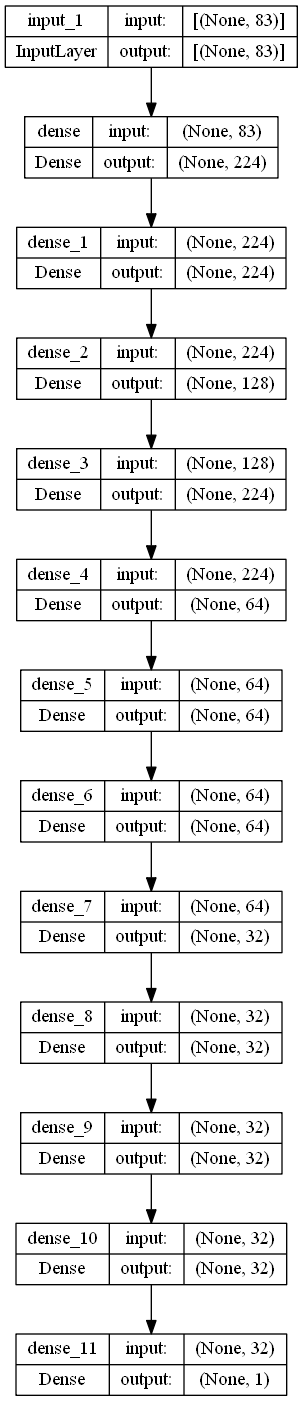

In [37]:
keras.utils.plot_model(model_ann, 'model_ann_system_level_bike_rental_demand_philadelphia.png', show_shapes=True)

**Train the model:**

For **performance reasons**, the model was **only trained for 20 epochs** in hyperparameter tuning.  
That is why we are **now continuing to train** the model to achieve the **best possible result**.

Define a callback that stops earlier if there is no further improvement, restores the model weights from the epoch with the best value of val_loss, and prevents overfitting by monitoring val_loss:

In [38]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100, 
    restore_best_weights=True 
    )

In [39]:
model_ann.fit(x_train, y_train, epochs=1000, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/1000
137/137 [==============================] - 1s 4ms/step - loss: 80.3155 - val_loss: 427.9492
Epoch 2/1000
137/137 [==============================] - 0s 3ms/step - loss: 72.6745 - val_loss: 414.4531
Epoch 3/1000
137/137 [==============================] - 0s 3ms/step - loss: 67.8054 - val_loss: 414.0729
Epoch 4/1000
137/137 [==============================] - 0s 3ms/step - loss: 51.4383 - val_loss: 450.9688
Epoch 5/1000
137/137 [==============================] - 0s 3ms/step - loss: 53.6119 - val_loss: 396.5309
Epoch 6/1000
137/137 [==============================] - 0s 3ms/step - loss: 46.2112 - val_loss: 403.1279
Epoch 7/1000
137/137 [==============================] - 0s 3ms/step - loss: 49.5770 - val_loss: 401.2034
Epoch 8/1000
137/137 [==============================] - 0s 3ms/step - loss: 48.5295 - val_loss: 410.3672
Epoch 9/1000
137/137 [==============================] - 0s 3ms/step - loss: 32.7504 - val_loss: 405.0034
Epoch 10/1000
137/137 [==============================] 

137/137 [==============================] - 0s 3ms/step - loss: 17.2736 - val_loss: 379.4322
Epoch 79/1000
137/137 [==============================] - 0s 3ms/step - loss: 44.6366 - val_loss: 384.4960
Epoch 80/1000
137/137 [==============================] - 0s 3ms/step - loss: 34.7596 - val_loss: 389.7782
Epoch 81/1000
137/137 [==============================] - 0s 3ms/step - loss: 23.7392 - val_loss: 362.7327
Epoch 82/1000
137/137 [==============================] - 0s 3ms/step - loss: 14.8573 - val_loss: 369.7558
Epoch 83/1000
137/137 [==============================] - 0s 3ms/step - loss: 15.3475 - val_loss: 371.5116
Epoch 84/1000
137/137 [==============================] - 0s 3ms/step - loss: 14.0899 - val_loss: 380.9190
Epoch 85/1000
137/137 [==============================] - 0s 3ms/step - loss: 15.0821 - val_loss: 376.1104
Epoch 86/1000
137/137 [==============================] - 0s 3ms/step - loss: 14.9675 - val_loss: 369.8408
Epoch 87/1000
137/137 [==============================] - 0s 

137/137 [==============================] - 0s 3ms/step - loss: 10.2332 - val_loss: 382.1151
Epoch 156/1000
137/137 [==============================] - 0s 3ms/step - loss: 12.7729 - val_loss: 353.4801
Epoch 157/1000
137/137 [==============================] - 0s 3ms/step - loss: 8.1000 - val_loss: 360.2884
Epoch 158/1000
137/137 [==============================] - 0s 3ms/step - loss: 4.5275 - val_loss: 357.6682
Epoch 159/1000
137/137 [==============================] - 0s 3ms/step - loss: 4.1084 - val_loss: 361.0900
Epoch 160/1000
137/137 [==============================] - 0s 3ms/step - loss: 4.8667 - val_loss: 355.8507
Epoch 161/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.7075 - val_loss: 380.3589
Epoch 162/1000
137/137 [==============================] - 0s 3ms/step - loss: 11.7050 - val_loss: 363.0414
Epoch 163/1000
137/137 [==============================] - 0s 3ms/step - loss: 9.9271 - val_loss: 368.8087
Epoch 164/1000
137/137 [==============================] - 

137/137 [==============================] - 1s 4ms/step - loss: 16.8520 - val_loss: 361.9716
Epoch 233/1000
137/137 [==============================] - 1s 4ms/step - loss: 8.1507 - val_loss: 358.4825
Epoch 234/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.4138 - val_loss: 356.8367
Epoch 235/1000
137/137 [==============================] - 1s 4ms/step - loss: 3.9025 - val_loss: 356.0450
Epoch 236/1000
137/137 [==============================] - 1s 6ms/step - loss: 2.1901 - val_loss: 355.5600
Epoch 237/1000
137/137 [==============================] - 1s 6ms/step - loss: 1.6683 - val_loss: 350.1139
Epoch 238/1000
137/137 [==============================] - 1s 5ms/step - loss: 1.5307 - val_loss: 356.9713
Epoch 239/1000
137/137 [==============================] - 1s 4ms/step - loss: 1.2248 - val_loss: 354.5277
Epoch 240/1000
137/137 [==============================] - 1s 4ms/step - loss: 2.3792 - val_loss: 352.6052
Epoch 241/1000
137/137 [==============================] - 1s

137/137 [==============================] - 0s 3ms/step - loss: 4.0331 - val_loss: 360.6366
Epoch 310/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.9762 - val_loss: 355.9464
Epoch 311/1000
137/137 [==============================] - 0s 3ms/step - loss: 8.4936 - val_loss: 358.0856
Epoch 312/1000
137/137 [==============================] - 0s 3ms/step - loss: 7.9405 - val_loss: 366.9701
Epoch 313/1000
137/137 [==============================] - 0s 3ms/step - loss: 5.0330 - val_loss: 360.7979
Epoch 314/1000
137/137 [==============================] - 1s 4ms/step - loss: 4.3080 - val_loss: 358.7390
Epoch 315/1000
137/137 [==============================] - 0s 3ms/step - loss: 3.8532 - val_loss: 354.0406
Epoch 316/1000
137/137 [==============================] - 0s 3ms/step - loss: 42.4902 - val_loss: 363.1692
Epoch 317/1000
137/137 [==============================] - 0s 3ms/step - loss: 21.9409 - val_loss: 361.1644
Epoch 318/1000
137/137 [==============================] - 0

**Evaluation of the performance of the model:**

In [40]:
pred_ann = model_ann.predict(x_test)

# Calculate MAE and RMSE
mae_ann = mean_absolute_error(y_test,pred_ann)
rmse_ann = mean_squared_error(y_test,pred_ann)**0.5

print("MAE:", mae_ann)
print("RMSE:", rmse_ann)
print("Accuracy:", round((1-(mae_ann/dfPhiladelphiaIncluding0TripsUniqueHours["numOfRentedBikesHourly"].mean()))*100,2), "%")

83/83 [==============================] - 0s 1ms/step
MAE: 11.157224933487822
RMSE: 19.10622250419751
Accuracy: 83.41 %
